In [259]:
import fitsio
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.table as t
# importing all modules
import os
import fitsio
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import numpy as np
import astropy.table as t
import subprocess
import json 
import scipy.optimize as so
from scipy.integrate import odeint
import numpy.ma as ma
from scipy.stats import linregress
import pandas as pd
from scipy.stats import binned_statistic as bn
import pickle
from scipy.stats import norm

In [18]:
# checking which tiles have truth tables
trutab=t.Table.read('/global/cfs/cdirs/desi/sv/vi/TruthTables/Fuji/ELG/220505_ELG_SV1_blanc_and_Fuji_v1.csv')
trutab2=t.Table.read('/global/cfs/cdirs/desi/sv/vi/TruthTables/Fuji/LRG/220505_LRG_SV1_blanc_and_Fuji_v1.csv')
print(np.unique(trutab2['TILEID']))
print(np.unique(trutab['TILEID']))

TILEID
------
 80605
 80609
TILEID
------
 80606
 80608
 80610


In [19]:
# reading each fits file in emfit output
for filename in emlist:
    emread1= fitsio.FITS(filename)
print(emread1[1].read_header())


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  345 / width of table in bytes
NAXIS2  =                  500 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   80 / number of fields in each row
TTYPE1  = 'TARGETID'           / label for field   1
TFORM1  = 'K'                  / data format of field: 8-byte INTEGER
TTYPE2  = 'Z'                  / label for field   2
TFORM2  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE3  = 'ZWARN'              / label for field   3
TFORM3  = 'K'                  / data format of field: 8-byte INTEGER
TTYPE4  = 'SPECTYPE'           / label for field   4
TFORM4  = '6A'                 / data format of field: ASCII Character
TTYPE5  = 'DELTACHI2'          / label for f

In [78]:
def read_tile_catalog(tile_string):
    # Read galaxy catalog of a tile including line fit information of all objects
    # input: string with the ID of the tile, e.g. "80605"
    # returns: structured array with catalog of all objects in that tile
    
    emlist = glob.glob('/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/'+tile_string+'/*/emline*.fits')
    emtable = t.Table()
    for filename in emlist:
        emread2=fits.open(filename)
        dumtable=t.Table.read(emread2[1])
        dumtable['RRFN']=dumtable.meta['RRFN']
        dumtable['FN']=filename
        dumtable['COADDFN']=dumtable.meta['COADDFN']
        emtable=t.vstack([dumtable,emtable])
    
    return emtable

def filter_galaxies(catalog):
    # Filter catalog to only include galaxy targets among spectype and targets among different, return the filtered catalog
    return catalog[(catalog['SPECTYPE']=='GALAXY') & (catalog['OBJTYPE']=='TGT')]

def filter_good_fits(catalog, deltachi2=40):
    # Filter catalog to only include targets with no ZWARN flag and good deltachi2
    
    good = (catalog['ZWARN'] == 0) & (catalog['DELTACHI2']>deltachi2)
    return catalog[good]

def calculate_oii_oiii_matrix(catalog, oIIlimit=-3, oIIIlimit=-3):
    
    # return normalized matrix of whether OII and OIII fluxes are or are not compatible with physical fit
    
    matrix = np.zeros(4)
    # ordered as 'OII good, OIII good', 'good, bad', 'bad, good', 'bad, bad' where bad means the significance of the respective flux is smaller than the limit passed to the function
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 > oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 > oIIIlimit)
    matrix[0] = np.sum(select)
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 > oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 <= oIIIlimit)
    matrix[1] = np.sum(select)
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 <= oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 > oIIIlimit)
    matrix[2] = np.sum(select)
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 <= oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 <= oIIIlimit)
    matrix[3] = np.sum(select)
    
    return matrix/np.sum(matrix)


def plot_matrices(matrices):
    
    matrices = np.array(matrices)
    
    # plt.hist(matrices[:,0], label="good OII & OIII",color='blue') hidden because we expect it to be -> 1
    plt.hist(matrices[:,1], label="good OII, bad OIII",bins=(np.linspace(0,0.1,100)),alpha=0.5)
    plt.hist(matrices[:,2], label="bad OII, good OIII",bins=(np.linspace(0,0.1,100)),alpha=0.5)
    plt.hist(matrices[:,3], label="bad OII & OIII",bins=(np.linspace(0,0.1,100)),alpha=0.5)
    plt.legend()
    plt.xlabel('Fraction of Galaxies')
    plt.ylabel('Frequency')

def calculateoiilinestrength(catalog):
    return (np.array(catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5))

def calculateoiiilinestrength(catalog):
    return (np.array(catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5))
    


In [4]:
tiles=["80653","80654","80655","80656","80657","80658","80659","80660","80661","80662","80663","80664","80665","80666","80669","80670","80673","80674","80675","80676","80677","80678","80679","80680","80681","80682","80683","80684","80685","80686","80687","80688","80689","80690","80691","80692","80693","80694","80695","80696","80697","80698","80699","80700","80701","80702","80703","80705","80706","80707","80708","80709","80710","80711","80712","80715","80718","80719","80720","80721","80722","80724","80726","80728","80729","80730","80731","80732","80733","80734","80735","80736","80737","80738","80740","80741","80742","80782","80783","80784","80785","80786","80787","80788","80789","80790","80856","80857","80858","80859","80860","80861","80862","80863","80865","80866","80867","80869","80870","80871","80872","80873","80875","80876","80879","80882","80885","80886","80887","80888","80889","80890","80891","80892","80893","80894","80895","80896","80897","80898","80899","80900","80901","80902","80938","80944","80949","80950","80951","80952","80954","80955","80956","80958","80959","80960","80962","80963","80966","80968","80970","80971","80972","80974","80975","81000","81001","81002","81003","81004","81005","81006","81007","81008","81009","81010","81011","81012","81013","81014","81015","81022","81056","81057","81058","81059","81060","81061","81062","81063","81064","81065","81066","81067","81068","81069","81072","81073","81074","81075","81088","81097","81098","81099","81100","81101","81102","81103","81104","81105","81106","81107","81108","81109","81110","81111","81112","81113","81114","81115"]
# tiles=["80653","80654","80655","80656","80657","80658","80659"] # if you want to test a particular file

In [ ]:
oiilinestrength=[]
oiiilinestrength=[]
matrices = []
matrices_good=[]
oiilinestrength_good=[]
oiiilinestrength_good=[]

for tile in tiles:
    print(tile)
    catalog = read_tile_catalog(tile)
    catalog = filter_galaxies(catalog)
    matrices.append(calculate_oii_oiii_matrix(catalog))
    oiilinestrength.append(calculateoiilinestrength(catalog))
    oiiilinestrength.append(calculateoiiilinestrength(catalog))
    catalog = filter_good_fits(catalog)
    oiilinestrength_good.append(calculateoiilinestrength(catalog))
    oiiilinestrength_good.append(calculateoiiilinestrength(catalog))
    matrices_good.append(calculate_oii_oiii_matrix(catalog))

# Pickling data
data = {'matrix from all the tiles Dr. Daniel': matrices,
    'Good Matrix from all the tiles Dr. Daniel provided': matrices_good,
       'oiilinestrength': oiilinestrength,
       'oiiilinestrength':oiiilinestrength,
       'oiilinestrength_good':oiilinestrength_good,
       'oiiilinestrength_good':oiiilinestrength_good,
       }
with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


In [2]:
# Extracting pickled data
with open('data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)

<Figure size 432x288 with 0 Axes>

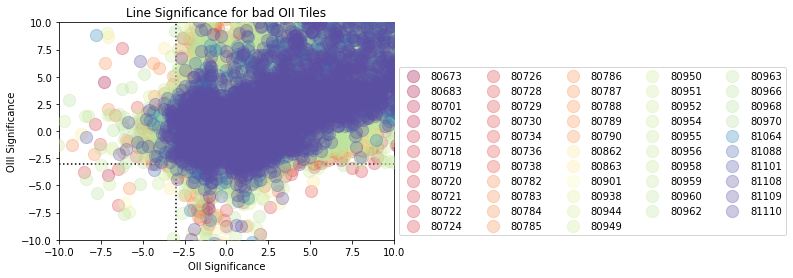

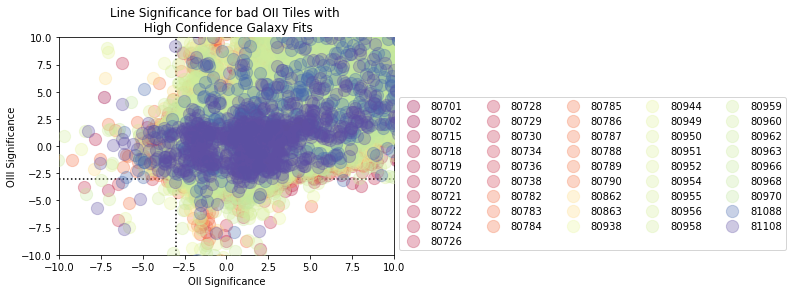

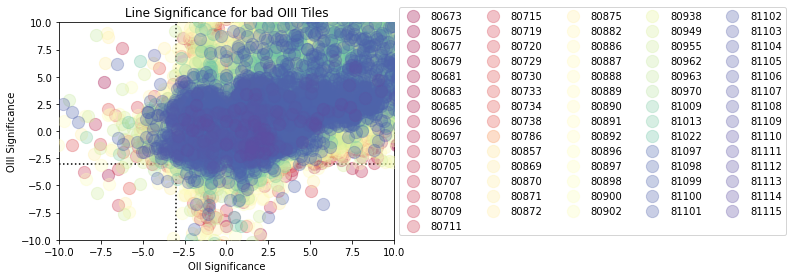

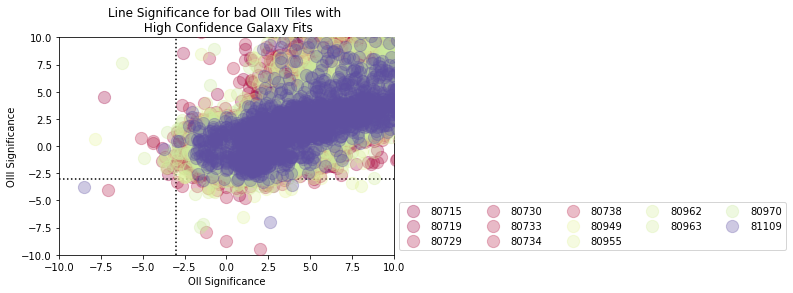

<Figure size 432x288 with 0 Axes>

In [222]:
# Correlation plots
cmap = plt.cm.Spectral
plt.figure()
norm = plt.Normalize(vmin=np.min(badoii), vmax=np.max(badoii))
plt.title('Line Significance for bad OII Tiles')
for i,tile in enumerate(badoii):
    plt.scatter(data['oiilinestrength'][i],data['oiiilinestrength'][i],zorder=i,alpha=0.3,s=150,color=cmap(norm(int(tile))),label=tile)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.legend(loc='lower left',bbox_to_anchor=(1,0),ncol=5)
plt.xlabel('OII Significance')
plt.axhline(-3,color='k',ls=':')
plt.axvline(-3,color='k',ls=':')
plt.ylabel('OIII Significance')
plt.figure()
norm = plt.Normalize(vmin=np.min(badoiisigfits), vmax=np.max(badoiisigfits))
for i,tile in enumerate(badoiisigfits):
    plt.scatter(data['oiilinestrength'][i],data['oiiilinestrength'][i],zorder=i,alpha=0.3,s=150,color=cmap(norm(int(tile))),label=tile)
plt.xlim(-10,10)
plt.axhline(-3,color='k',ls=':')
plt.axvline(-3,color='k',ls=':')
plt.ylim(-10,10)
plt.legend(loc='lower left',bbox_to_anchor=(1,0),ncol=5)
plt.title('Line Significance for bad OII Tiles with \n High Confidence Galaxy Fits')
plt.xlabel('OII Significance')
plt.ylabel('OIII Significance')
plt.figure()
norm = plt.Normalize(vmin=np.min(badoiii), vmax=np.max(badoiii))
plt.title('Line Significance for bad OIII Tiles')
for i,tile in enumerate(badoiii):
    plt.scatter(data['oiilinestrength'][i],data['oiiilinestrength'][i],zorder=i,alpha=0.3,s=150,color=cmap(norm(int(tile))),label=tile)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.axhline(-3,color='k',ls=':')
plt.axvline(-3,color='k',ls=':')
plt.legend(loc='lower left',bbox_to_anchor=(1,0),ncol=5)
plt.xlabel('OII Significance')
plt.ylabel('OIII Significance')
plt.figure()
norm = plt.Normalize(vmin=np.min(badoiiisigfits), vmax=np.max(badoiiisigfits))
plt.title('Line Significance for bad OIII Tiles with \n High Confidence Galaxy Fits')
for i,tile in enumerate(badoiiisigfits):
    plt.scatter(data['oiilinestrength'][i],data['oiiilinestrength'][i],zorder=i,alpha=0.3,s=150,color=cmap(norm(int(tile))),label=tile)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.axhline(-3,color='k',ls=':')
plt.axvline(-3,color='k',ls=':')
plt.legend(loc='lower left',bbox_to_anchor=(1,0),ncol=5)
plt.xlabel('OII Significance')
plt.ylabel('OIII Significance')
plt.figure()

In [210]:
badoii[0]

'80673'

Text(0, 0.5, 'OIII Significance')

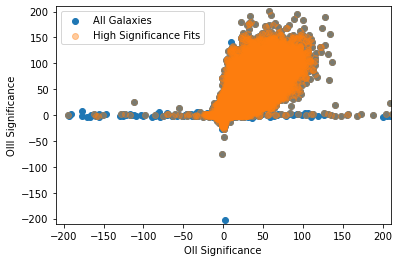

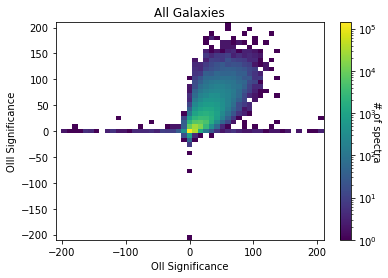

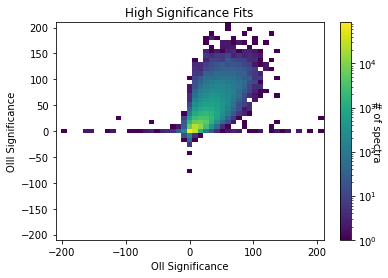

In [260]:
import matplotlib.colors
plt.scatter(oiisig,oiiisig,label='All Galaxies')
plt.scatter(oiisiggood,oiiisiggood,alpha=0.4,label='High Significance Fits')
plt.xlim(-210,210)
plt.ylim(-210,210)
plt.legend()
plt.xlabel('OII Significance')
plt.ylabel('OIII Significance')
plt.figure()
plt.hist2d(oiisig,oiiisig,bins=np.linspace(-210,210,50),norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
plt.title('All Galaxies')
cbar.ax.set_ylabel('# of spectra', rotation=270)
plt.xlabel('OII Significance')
plt.ylabel('OIII Significance')
plt.figure()
plt.hist2d(oiisiggood,oiiisiggood,bins=np.linspace(-210,210,50),norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
plt.title('High Significance Fits')
cbar.ax.set_ylabel('# of spectra', rotation=270)
plt.xlabel('OII Significance')
plt.ylabel('OIII Significance')

Text(0.5, 0, 'OII Significance')

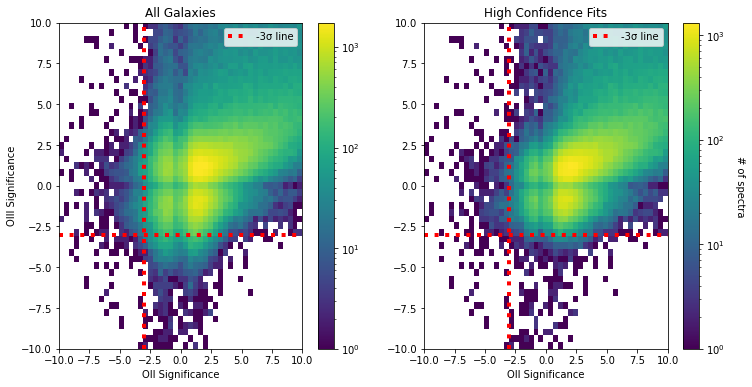

In [319]:
import matplotlib.colors
# plt.scatter(oiisig,oiiisig,label='All Galaxies')
# plt.scatter(oiisiggood,oiiisiggood,alpha=0.4,label='High Significance Fits')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
# plt.legend()
# plt.axhline(-3,color='red',ls=':',linewidth=4)
# plt.axvline(-3,color='red',ls=':',linewidth=4)
# plt.xlabel('OII Significance')
# plt.ylabel('OIII Significance')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist2d(oiisig,oiiisig,bins=np.linspace(-10,10,50),norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
plt.axhline(-3,color='red',ls=':',linewidth=4)
plt.axvline(-3,color='red',ls=':',linewidth=4, label='-3\u03C3 line')
plt.legend()
plt.title('All Galaxies')
plt.xlabel('OII Significance')
plt.ylabel('OIII Significance')
plt.subplot(1,2,2)
plt.axhline(-3,color='red',ls=':',linewidth=4)
plt.axvline(-3,color='red',ls=':',linewidth=4, label='-3\u03C3 line')
plt.legend()
plt.hist2d(oiisiggood,oiiisiggood,bins=np.linspace(-10,10,50),norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
plt.title('High Confidence Fits')
cbar.ax.set_ylabel('# of spectra', rotation=270,labelpad=20)
plt.xlabel('OII Significance')

cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=80600, vmax=81200)
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.title('OII Line Significance')
for i,tile in enumerate(tiles):
    plt.hist(data['oiilinestrength'][i],color=cmap(norm(int(tile))),zorder=200-i,bins=np.linspace(-20.1,0.3,103),alpha=0.2)   
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.text(-20,90,'zorder - VIBGYOR')
plt.subplot(2, 2, 2)
plt.title('OIII Line Significance')
for i,tile in enumerate(tiles):
    plt.hist(data['oiiilinestrength'][i],color=cmap(norm(int(tile))),zorder=i,bins=np.linspace(-20.1,0.3,103),alpha=0.2)   
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.text(-20,70,'zorder - VIBGYOR')
plt.subplot(2, 2, 3)
plt.title('OII Line Significance for \n High Confidence Galaxy Fits')
for i,tile in enumerate(tiles):
    plt.hist(data['oiilinestrength_good'][i],color=cmap(norm(int(tile))),zorder=i,bins=np.linspace(-20.1,0.3,103),alpha=0.2) 
plt.ylim(0,136) # adjusted according to the default plot
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.text(-20,90,'zorder - ROYGBIV')
plt.subplot(2, 2, 4)
plt.title('OIII Line Significance for \n High Confidence Galaxy Fits') 
for i,tile in enumerate(tiles):
    plt.hist(data['oiiilinestrength_good'][i],color=cmap(norm(int(tile))),zorder=i,bins=np.linspace(-20.1,0.3,103),alpha=0.2,label=tile) 
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.text(-20,70,'zorder - ROYGBIV')
plt.ylim(0,83) # adjusted according to the default plot
plt.subplots_adjust(hspace=0.4)
plt.legend(loc='lower left',bbox_to_anchor=(1,-0.15),ncol=5,title="TILES' COLOR CODE")

cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=80600, vmax=81200)
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.title('OII Line Significance')
for i,tile in enumerate(tiles):
    plt.hist(data['oiilinestrength'][i],color=cmap(norm(int(tile))),zorder=200-i,bins=np.linspace(-.3,0.3,40),alpha=0.2)   
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.subplot(2, 2, 2)
plt.title('OIII Line Significance')
for i,tile in enumerate(tiles):
    plt.hist(data['oiiilinestrength'][i],color=cmap(norm(int(tile))),zorder=200-i,bins=np.linspace(-.3,0.3,40),alpha=0.2)   
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.subplot(2, 2, 3)
plt.title('OII Line Significance for \n High Confidence Galaxy Fits')
for i,tile in enumerate(tiles):
    plt.hist(data['oiilinestrength_good'][i],color=cmap(norm(int(tile))),zorder=i,bins=np.linspace(-.3,0.3,40),alpha=0.2) 
plt.ylim(0,136) # adjusted according to the default plot
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.subplot(2, 2, 4)
plt.title('OIII Line Significance for \n High Confidence Galaxy Fits') 
for i,tile in enumerate(tiles):
    plt.hist(data['oiiilinestrength_good'][i],color=cmap(norm(int(tile))),zorder=i,bins=np.linspace(-.3,0.3,40),alpha=0.2,label=tile) 
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.ylim(0,83) # adjusted according to the default plot
plt.subplots_adjust(hspace=0.4)
plt.legend(loc='lower left',bbox_to_anchor=(1,-0.15),ncol=5,title="TILES' COLOR CODE")

area is 9003.600000000002
area is 2219.0000000000005
area is 10993.600000000002
area is 6052.4000000000015


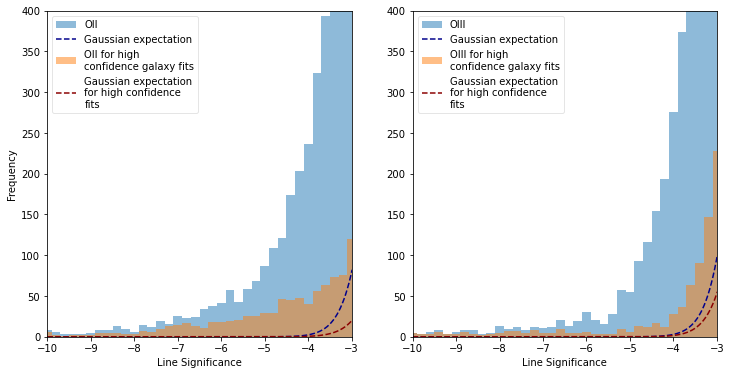

In [318]:
oiisig = np.array([item for sublist in data['oiilinestrength'] for item in sublist])
oiiisig = np.array([item for sublist in data['oiiilinestrength'] for item in sublist])
oiisiggood = np.array([item for sublist in data['oiilinestrength_good'] for item in sublist])
oiiisiggood = np.array([item for sublist in data['oiiilinestrength_good'] for item in sublist])
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.xlim(-10,-3)
values, bins, _ =plt.hist(oiisig,bins=np.linspace(-10.1,10.1,102),alpha=0.5,label='OII')
ar=np.sum(values[0:50]*np.diff(bins[0:51]))
print('area is',ar)
x_axis = np.arange(-10, 10, 0.01)
mu=0
sig=1
plt.plot(x_axis, 2*ar*norm.pdf(x_axis, mu, sig),color='darkblue',linestyle='--',label='Gaussian expectation')
values, bins, _ =plt.hist(oiisiggood,bins=np.linspace(-10.1,10.1,102),alpha=0.5,label='OII for high\nconfidence galaxy fits')
ar=np.sum(values[0:50]*np.diff(bins[0:51]))
print('area is',ar)
x_axis = np.arange(-10, 10, 0.01)
mu=0
sig=1
plt.plot(x_axis, 2*ar*norm.pdf(x_axis, mu, sig),color='darkred',linestyle='--',label='Gaussian expectation\nfor high confidence\nfits')
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.ylim(0,400)
plt.legend(loc='best',fancybox=True, framealpha=0.5)
plt.subplot(1, 2, 2)
values, bins, _ =plt.hist(oiiisig,bins=np.linspace(-10.1,10.1,102),alpha=0.5,label='OIII')
ar=np.sum(values[0:50]*np.diff(bins[0:51]))
print('area is',ar)
x_axis = np.arange(-10, 10, 0.01)
mu=0
sig=1
plt.plot(x_axis, 2*ar*norm.pdf(x_axis, mu, sig),color='darkblue',linestyle='--',label='Gaussian expectation')
values, bins, _ =plt.hist(oiiisiggood,bins=np.linspace(-10.1,10.1,102),alpha=0.5,label='OIII for high\nconfidence galaxy fits')
ar=np.sum(values[0:50]*np.diff(bins[0:51]))
print('area is',ar)
x_axis = np.arange(-10, 10, 0.01)
mu=0
sig=1
plt.plot(x_axis, 2*ar*norm.pdf(x_axis, mu, sig),color='darkred',linestyle='--',label='Gaussian expectation\nfor high confidence\nfits')
plt.xlabel('Line Significance')
# plt.yscale('log')
plt.xlim(-10,-3) # adjusted according to the default plot
plt.ylim(0,400)
plt.subplots_adjust(hspace=0.4)
plt.legend(loc='best',fancybox=True, framealpha=0.5)


area is 9003.600000000002
area is 2219.0000000000005
area is 10993.600000000002
area is 6052.4000000000015


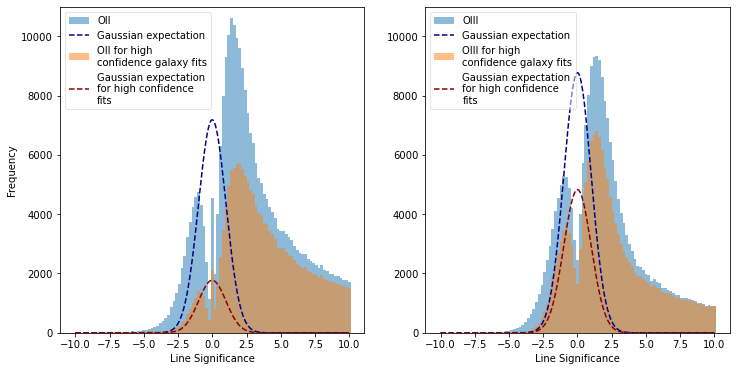

In [320]:
oiisig = np.array([item for sublist in data['oiilinestrength'] for item in sublist])
oiiisig = np.array([item for sublist in data['oiiilinestrength'] for item in sublist])
oiisiggood = np.array([item for sublist in data['oiilinestrength_good'] for item in sublist])
oiiisiggood = np.array([item for sublist in data['oiiilinestrength_good'] for item in sublist])
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
values, bins, _ =plt.hist(oiisig,bins=np.linspace(-10.1,10.1,102),alpha=0.5,label='OII')
ar=np.sum(values[0:50]*np.diff(bins[0:51]))
print('area is',ar)
x_axis = np.arange(-10, 10, 0.01)
mu=0
sig=1
plt.plot(x_axis, 2*ar*norm.pdf(x_axis, mu, sig),color='darkblue',linestyle='--',label='Gaussian expectation')
values, bins, _ =plt.hist(oiisiggood,bins=np.linspace(-10.1,10.1,102),alpha=0.5,label='OII for high\nconfidence galaxy fits')
ar=np.sum(values[0:50]*np.diff(bins[0:51]))
print('area is',ar)
x_axis = np.arange(-10, 10, 0.01)
mu=0
sig=1
plt.plot(x_axis, 2*ar*norm.pdf(x_axis, mu, sig),color='darkred',linestyle='--',label='Gaussian expectation\nfor high confidence\nfits')
plt.xlabel('Line Significance')
plt.ylabel('Frequency')
plt.ylim(0,11000)
plt.legend(loc='best',fancybox=True, framealpha=0.5)
plt.subplot(1, 2, 2)
values, bins, _ =plt.hist(oiiisig,bins=np.linspace(-10.1,10.1,102),alpha=0.5,label='OIII')
ar=np.sum(values[0:50]*np.diff(bins[0:51]))
print('area is',ar)
x_axis = np.arange(-10, 10, 0.01)
mu=0
sig=1
plt.plot(x_axis, 2*ar*norm.pdf(x_axis, mu, sig),color='darkblue',linestyle='--',label='Gaussian expectation')
values, bins, _ =plt.hist(oiiisiggood,bins=np.linspace(-10.1,10.1,102),alpha=0.5,label='OIII for high\nconfidence galaxy fits')
ar=np.sum(values[0:50]*np.diff(bins[0:51]))
print('area is',ar)
x_axis = np.arange(-10, 10, 0.01)
mu=0
sig=1
plt.plot(x_axis, 2*ar*norm.pdf(x_axis, mu, sig),color='darkred',linestyle='--',label='Gaussian expectation\nfor high confidence\nfits')
plt.xlabel('Line Significance')
# plt.yscale('log')
# plt.xlim(-10,-3) # adjusted according to the default plot
plt.ylim(0,11000)
plt.subplots_adjust(hspace=0.4)
plt.legend(loc='best',fancybox=True, framealpha=0.5)


###### 0.1/0.0015

53 Tiles with sig -ve OII
71 Tiles with sig -ve OIII
46 Tiles with sig -ve OII with good fits
13 Tiles with sig -ve OIII with good fits


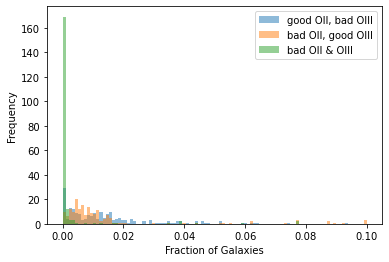

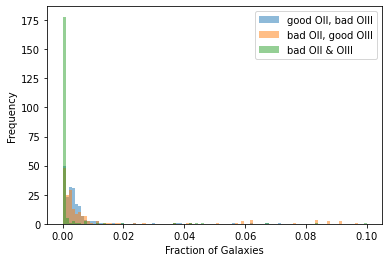

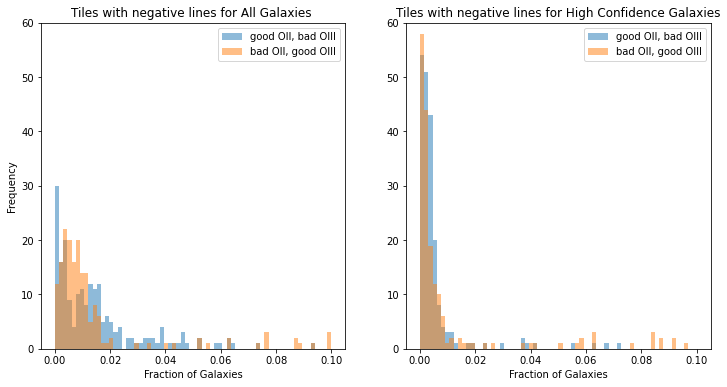

In [322]:
# Histogram plots
plt.figure()
plot_matrices(data['matrix from all the tiles Dr. Daniel'])
plt.figure()
plot_matrices(data['Good Matrix from all the tiles Dr. Daniel provided'])
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
# fract. gal hist plots without 00
matricesdum = np.array(data['matrix from all the tiles Dr. Daniel'])
plt.hist(matricesdum[:,1], label="good OII, bad OIII",bins=(np.linspace(0,0.1,67)),alpha=0.5)
plt.hist(matricesdum[:,2], label="bad OII, good OIII",bins=(np.linspace(0,0.1,67)),alpha=0.5)
plt.xlabel('Fraction of Galaxies')
plt.ylabel('Frequency')
plt.title('Tiles with negative lines for All Galaxies ')
plt.legend()
plt.ylim(0,60)
plt.subplot(1,2,2)
# good fract. gal hist plots without 00
matricesgooddum = np.array(data['Good Matrix from all the tiles Dr. Daniel provided'])
plt.hist(matricesgooddum[:,1], label="good OII, bad OIII",bins=(np.linspace(0,0.1,67)),alpha=0.5)
plt.hist(matricesgooddum[:,2], label="bad OII, good OIII",bins=(np.linspace(0,0.1,67)),alpha=0.5)
plt.xlabel('Fraction of Galaxies')
plt.title('Tiles with negative lines for High Confidence Galaxies')
plt.legend()
plt.ylim(0,60)
print(len(badoii),'Tiles with sig -ve OII')
print(len(badoiii),'Tiles with sig -ve OIII')
print(len(badoiisigfits),'Tiles with sig -ve OII with good fits')
print(len(badoiiisigfits),'Tiles with sig -ve OIII with good fits')

In [310]:
0.1/67

0.0014925373134328358

In [213]:
tilenum=np.array(tiles)
badoiii=tilenum[[i[1]>0.015 for i in data['matrix from all the tiles Dr. Daniel']]]
badoii=tilenum[[i[2]>0.015 for i in data['matrix from all the tiles Dr. Daniel']]]

badoiiisigfits=tilenum[[i[1]>0.015 for i in data['Good Matrix from all the tiles Dr. Daniel provided']]]
badoiisigfits=tilenum[[i[2]>0.015 for i in data['Good Matrix from all the tiles Dr. Daniel provided']]]

badoii=[int(i) for i in badoii]
badoiisigfits=[int(i) for i in badoiisigfits]
badoiii=[int(i) for i in badoiii]
badoiiisigfits=[int(i) for i in badoiiisigfits]
print(len(badoii),'Tiles with sig -ve OII')
print(len(badoiisigfits),'Tiles with sig -ve OII with good fits')
print(len(badoiii),'Tiles with sig -ve OIII')
print(len(badoiiisigfits),'Tiles with sig -ve OIII with good fits')

53 Tiles with sig -ve OII
46 Tiles with sig -ve OII with good fits
71 Tiles with sig -ve OIII
13 Tiles with sig -ve OIII with good fits


In [214]:
badoii[0]

80673

In [161]:
print(len(oiisig[oiisig<-3])/len(oiisig)*100)
print(np.sum(oiisiggood<-3)/len(oiisiggood)*100)
print(np.sum(oiiisig<-3)/len(oiiisig)*100)
print(np.sum(oiiisiggood<-3)/len(oiiisiggood)*100)

1.1367110351955823
0.45149352004186577
1.0612538031900698
0.2879981392994326


In [120]:
tiles[i[1]>0.015 for i in data['matrix from all the tiles Dr. Daniel']]

SyntaxError: invalid syntax (3696235409.py, line 1)

In [145]:
tilenum=np.array(tiles)
tilenum[[i[1]>0.015 for i in data['matrix from all the tiles Dr. Daniel']]]

array(['80673', '80675', '80677', '80679', '80681', '80683', '80685',
       '80696', '80697', '80703', '80705', '80707', '80708', '80709',
       '80711', '80715', '80719', '80720', '80729', '80730', '80733',
       '80734', '80738', '80786', '80857', '80869', '80870', '80871',
       '80872', '80875', '80882', '80886', '80887', '80888', '80889',
       '80890', '80891', '80892', '80896', '80897', '80898', '80900',
       '80902', '80938', '80949', '80955', '80962', '80963', '80970',
       '81009', '81013', '81022', '81097', '81098', '81099', '81100',
       '81101', '81102', '81103', '81104', '81105', '81106', '81107',
       '81108', '81109', '81110', '81111', '81112', '81113', '81114',
       '81115'], dtype='<U5')

a=data['oiilinestrength'][1][~np.isnan(data['oiilinestrength'][1])]
b=data['oiiilinestrength'][1][~np.isnan(data['oiiilinestrength'][1])]
print(a)
plt.hist2d(a,b)

In [127]:
np.argwhere(np.isnan(data['oiiilinestrength_good'][-1]))

array([[ 51],
       [ 58],
       [ 61],
       [ 73],
       [ 80],
       [ 87],
       [ 88],
       [ 90],
       [ 91],
       [ 95],
       [ 99],
       [134],
       [141],
       [158],
       [183],
       [186],
       [270],
       [285],
       [294],
       [332],
       [349]])

In [128]:
catalog[55]

TARGETID,Z,ZWARN,SPECTYPE,DELTACHI2,TARGET_RA,TARGET_DEC,OBJTYPE,OII_FLUX,OII_FLUX_IVAR,OII_SIGMA,OII_SIGMA_IVAR,OII_CONT,OII_CONT_IVAR,OII_SHARE,OII_SHARE_IVAR,OII_EW,OII_EW_IVAR,OII_CHI2,OII_NDOF,HDELTA_FLUX,HDELTA_FLUX_IVAR,HDELTA_SIGMA,HDELTA_SIGMA_IVAR,HDELTA_CONT,HDELTA_CONT_IVAR,HDELTA_SHARE,HDELTA_SHARE_IVAR,HDELTA_EW,HDELTA_EW_IVAR,HDELTA_CHI2,HDELTA_NDOF,HGAMMA_FLUX,HGAMMA_FLUX_IVAR,HGAMMA_SIGMA,HGAMMA_SIGMA_IVAR,HGAMMA_CONT,HGAMMA_CONT_IVAR,HGAMMA_SHARE,HGAMMA_SHARE_IVAR,HGAMMA_EW,HGAMMA_EW_IVAR,HGAMMA_CHI2,HGAMMA_NDOF,HBETA_FLUX,HBETA_FLUX_IVAR,HBETA_SIGMA,HBETA_SIGMA_IVAR,HBETA_CONT,HBETA_CONT_IVAR,HBETA_SHARE,HBETA_SHARE_IVAR,HBETA_EW,HBETA_EW_IVAR,HBETA_CHI2,HBETA_NDOF,OIII_FLUX,OIII_FLUX_IVAR,OIII_SIGMA,OIII_SIGMA_IVAR,OIII_CONT,OIII_CONT_IVAR,OIII_SHARE,OIII_SHARE_IVAR,OIII_EW,OIII_EW_IVAR,OIII_CHI2,OIII_NDOF,HALPHA_FLUX,HALPHA_FLUX_IVAR,HALPHA_SIGMA,HALPHA_SIGMA_IVAR,HALPHA_CONT,HALPHA_CONT_IVAR,HALPHA_SHARE,HALPHA_SHARE_IVAR,HALPHA_EW,HALPHA_EW_IVAR,HALPHA_CHI2,HALPHA_NDOF,RRFN,FN,COADDFN
int64,float64,int64,str6,float64,float64,float64,str3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,str107,str106,str105
39633441326630842,0.07266766201642973,0,GALAXY,95.86408092826605,285.65672787545054,64.83578979675036,TGT,--,--,--,--,2.0164614,0.011288561,--,--,--,--,--,-99,39.883003,0.0016922519,5.3412204,0.07097352,1.4816047,0.037486583,--,--,28.874914,0.003228489,22998.445,102,21.780874,0.009734849,1.7015084,1.2346551,1.7274393,0.06565443,--,--,13.525014,0.025246691,3262.1387,106,3.6952553,0.05618555,0.71185106,1.2239658,1.7449406,0.15564144,--,--,2.271585,0.14868104,227.2548,105,31.560385,0.036274265,0.7482039,48.312134,1.6631469,0.17273483,0.744,inf,20.35527,0.0872026,207.65488,169,30.2435,0.15997739,0.9576757,126.03385,0.6646483,0.6957831,--,--,48.809612,0.061420307,3.3187616,105,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/redrock-2-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-2-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/coadd-2-81115-thru20210513.fits


In [81]:
outdict={}
problematic =(catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5<-30) #managable
for fn in np.unique(catalog[problematic]['COADDFN']):
    entries=catalog[problematic][catalog[problematic]['COADDFN']==fn]
    fnrr=entries['RRFN'][0]
    rrf=fitsio.FITS(fnrr)
    fobj=fitsio.FITS(fn)
    fm=fobj['FIBERMAP']
    tids=fm['TARGETID'][:]
    for entry in entries:
        if entry['TARGETID'] in tids:
            index=(fm['TARGETID'][:]==entry['TARGETID']).nonzero()[0]
            print(index, entry['TARGETID'])
            outdict[entry['TARGETID']]={'wave':[],'flux':[],'ivar':[],'mask':[],'redshift':entry['Z']}            
            for color in 'BRZ':
                outdict[entry['TARGETID']]['wave'].append(fobj[f'{color}_WAVELENGTH'][:])
                outdict[entry['TARGETID']]['flux'].append(fobj[f'{color}_FLUX'][index:index+1,:][0])
                outdict[entry['TARGETID']]['ivar'].append(fobj[f'{color}_IVAR'][index:index+1,:][0])
                outdict[entry['TARGETID']]['mask'].append(fobj[f'{color}_MASK'][index:index+1,:][0])


NameError: name 'catalog' is not defined

In [69]:
len(oiilinestrength_good[-1])

384

In [ ]:
fig,ax_all=plt.subplots(len(outdict),figsize=(20,5*len(outdict)))
for ax,(tid, tdict) in zip(ax_all,outdict.items()):
    for j,(w,f,i,m) in enumerate(zip(tdict['wave'],tdict['flux'],tdict['ivar'],tdict['mask'])):
        ax.plot(w[m==0],f[m==0],color='k',label='flux' if j==0 else '')
        ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
        ax.plot(w,m,color='g',label='mask' if j==0 else '')
        ax.set_title(tid)
        ax.set_ylim(-10,100)
        ax.axvline(3726*(1+tdict['redshift']),ls=':')
        
        ax.axvline(3729*(1+tdict['redshift']),ls=':')
        ax.set_xlim(3726*(1+tdict['redshift'])-200,3726*(1+tdict['redshift'])+200)
        ax.legend()
        print(tdict['redshift'])
        
#1.105 is the 1+z for those objects, please read those from the respective RRFN
#5000 is the ~ wavelength of the OIII doublet, needs to be adapted for OII

In [ ]:
print(tdict['redshift'])

In [80]:
catalog

NameError: name 'catalog' is not defined